<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/unified_approach/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Forecasting and prediction



---



---



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV



df_3_clusters_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered_3.csv"
df_4_clusters_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered_4.csv"
df_5_clusters_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered_5.csv"
df_url = "https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/main/datasets/unified_approach/df_ma.csv"

df = pd.read_csv(df_url)
df_3_clusters = pd.read_csv(df_3_clusters_url)
df_4_clusters = pd.read_csv(df_4_clusters_url)
df_5_clusters = pd.read_csv(df_5_clusters_url)

# Convert numerical columns to string
for i, curr_df in enumerate([df, df_3_clusters, df_4_clusters, df_5_clusters]):
    numerical_columns = ['HOSPI_CODE_UCD']
    curr_df[numerical_columns] = curr_df[numerical_columns].astype('string')


medicines = [3400892088310,3400892075761,3400892203645,
             3400892065366,3400892052120,3400891996128,
             3400893826706,3400893736135,3400893875490,
             3400890837149,3400891235203,3400891225037,
             3400891191226,3400892729589,3400892745848,
             3400892697789,3400892761527,3400893022634,
             3400892761695,3400892669236,3400892508566]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4074 entries, 0 to 4073
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HOSPI_CODE_UCD     4074 non-null   string 
 1   LIT_HC             4074 non-null   float64
 2   LIT_HP             4074 non-null   float64
 3   N_ETB              4074 non-null   float64
 4   N_UFS              4074 non-null   float64
 5   PN_MEDICAL         4074 non-null   float64
 6   POPULATION         4074 non-null   float64
 7   P_MEDICAL          4074 non-null   float64
 8   QUANTITY           4074 non-null   float64
 9   QUANTITY_MA        4074 non-null   float64
 10  SEJ_HAD            4074 non-null   float64
 11  SEJ_MCO            4074 non-null   float64
 12  SEJ_PSY            4074 non-null   float64
 13  SEJ_SLD            4074 non-null   float64
 14  SEJ_SSR            4074 non-null   float64
 15  MONTH_1.0          4074 non-null   int64  
 16  MONTH_2.0          4074 

## 5.1 - New database composition based on clusters

## 5.2 - Building forecasting models based on clusters

In [38]:
def plot_pred(y_pred, y_test, medicine):
    # Plot y_pred as scatter with confidence intervals
    x = np.arange(len(y_pred))  # x-axis values
    plt.scatter(x, y_pred, label='y_pred', marker='.')

    # Plot y_test as scatter
    plt.scatter(x, y_test, label='y_test', marker='x')

    # Set labels and title
    plt.xlabel('Test samples')
    plt.ylabel('Quantity')
    plt.title(f'y_pred and y_test for medicine: {medicine}')
    plt.grid(True)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


In [3]:
def test_1_baseline(df, medicine, df_scores):
  print()
  print(100*'-')
  print('Medicine:' + str(medicine))

  X = df[df['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD'], axis=1).values

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  y = df[df['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].values

  X_scaled, y = shuffle(X_scaled, y, random_state=42)

  if m.ceil(len(X_scaled) * 0.1) == 1:
    print('Dataset too small')
    test_size = 2
  else:
    test_size = 0.1
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                      test_size = test_size,
                                                      random_state = 42)
  print(f'Size of data set: {len(X)}')
  print(f'Size of training set: {len(X_train)}')
  print(f'Size of test set: {len(X_test)}')

  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt', 'log2', 1]
  }
  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                             param_grid=param_grid,
                             scoring = 'r2',
                             cv = 5,
                             n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''
  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best estimator
  best_estimator = grid_search.best_estimator_

  # Make predictions using the best estimator
  y_pred = best_estimator.predict(X_test)

  # Calculate R^2 score
  r2 = r2_score(y_test, y_pred)

  # Calculate MAE
  mae = mean_absolute_error(y_test, y_pred)

  # Calculate MAPE
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  # Print the best parameters, best score, and evaluation metrics

  print(f'Datapoints in test: {len(X_test)}')
  print('Best Parameters:', grid_search.best_params_)
  print('Training Score: R^2', round(grid_search.best_score_, 3))
  print('Test score: ')
  print('R^2 Score:', round(r2, 3))
  print('MAE:', round(mae, 3))
  print('MAPE:', round(mape, 3))
  print('RMSE:', round(rmse, 3))
  print()


  # Create the new row as a DataFrame
  new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                          'R2': [r2],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'MAPE': [mape]})

  # Append the new row to the DataFrame
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)

  # plot pred x test
  plot_pred(y_pred, y_test, medicine)
  print()

  # Return the updated DataFrame
  return df_scores


In [4]:
features = ['HOSPI_CODE_UCD', 'LIT_HC', 'LIT_HP', 'N_ETB', 'N_UFS', 'PN_MEDICAL',
       'POPULATION', 'P_MEDICAL', 'QUANTITY', 'QUANTITY_MA', 'SEJ_HAD',
       'SEJ_MCO', 'SEJ_PSY', 'SEJ_SLD', 'SEJ_SSR', 'MONTH_1.0', 'MONTH_2.0',
       'MONTH_3.0', 'MONTH_4.0', 'MONTH_5.0', 'MONTH_6.0', 'MONTH_7.0',
       'MONTH_8.0', 'MONTH_9.0', 'MONTH_10.0', 'MONTH_11.0', 'MONTH_12.0']


----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Size of data set: 171
Size of training set: 153
Size of test set: 18
Size of grid search: 84
Datapoints in test: 18
Best Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 8}
Training Score: R^2 0.77
Test score: 
R^2 Score: 0.708
MAE: 720.812
MAPE: 0.487
RMSE: 1039.401



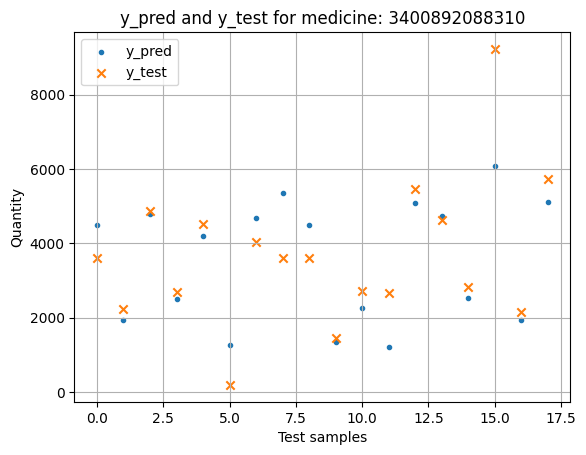



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Size of data set: 204
Size of training set: 183
Size of test set: 21
Size of grid search: 102
Datapoints in test: 21
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 18}
Training Score: R^2 0.63
Test score: 
R^2 Score: 0.411
MAE: 385.03
MAPE: 0.144
RMSE: 637.729



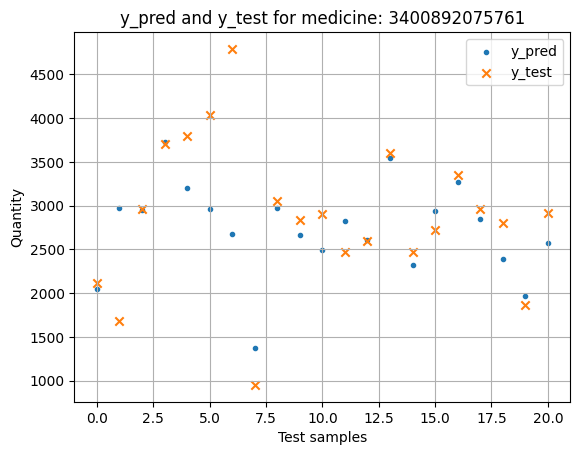



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Size of data set: 200
Size of training set: 180
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 13}
Training Score: R^2 0.86
Test score: 
R^2 Score: 0.924
MAE: 708.463
MAPE: 1.03
RMSE: 1090.205



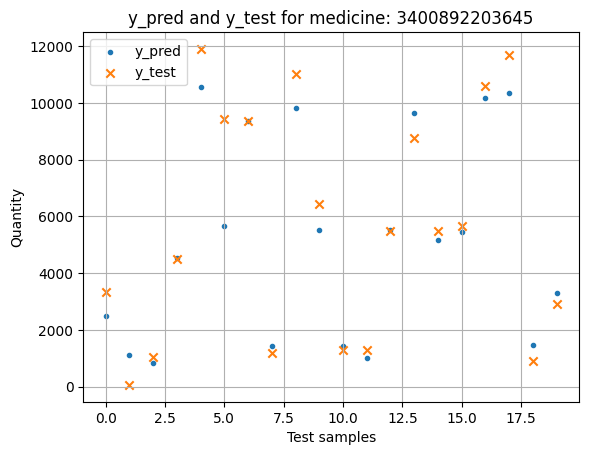



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Datapoints in test: 21
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 3}
Training Score: R^2 0.737
Test score: 
R^2 Score: 0.706
MAE: 710.501
MAPE: 0.745
RMSE: 1221.086



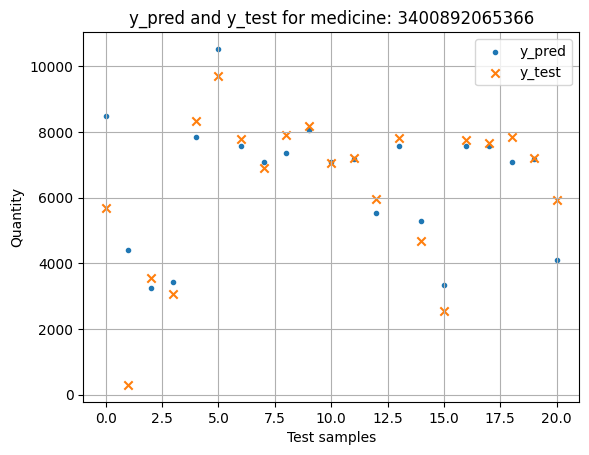



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Size of data set: 195
Size of training set: 175
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score: R^2 0.666
Test score: 
R^2 Score: 0.905
MAE: 220.996
MAPE: 1.931
RMSE: 321.271



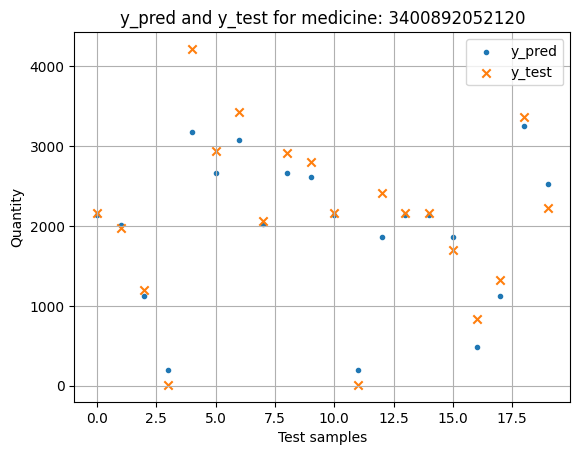



----------------------------------------------------------------------------------------------------
Medicine:3400891996128
Size of data set: 205
Size of training set: 184
Size of test set: 21
Size of grid search: 102
Datapoints in test: 21
Best Parameters: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 4}
Training Score: R^2 0.779
Test score: 
R^2 Score: 0.897
MAE: 8777.961
MAPE: 12.776
RMSE: 10693.293



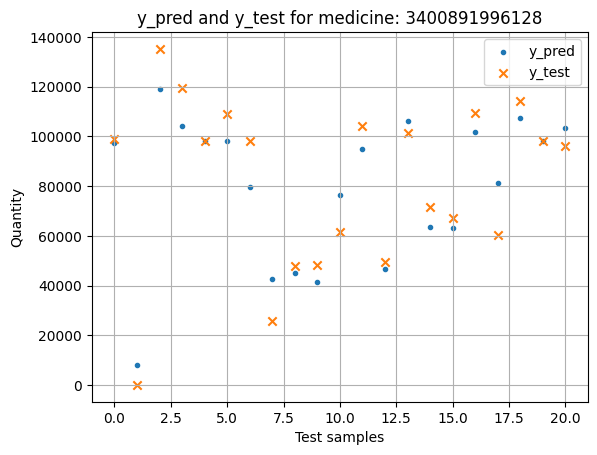



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Datapoints in test: 21
Best Parameters: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 16}
Training Score: R^2 0.869
Test score: 
R^2 Score: 0.823
MAE: 783.299
MAPE: 4.255
RMSE: 1167.965



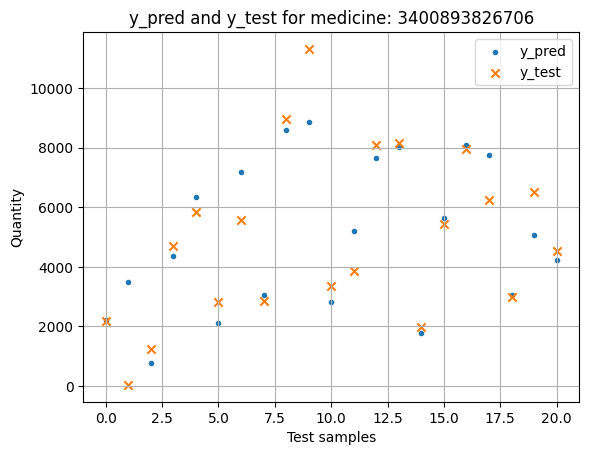



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Size of data set: 197
Size of training set: 177
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 9}
Training Score: R^2 0.855
Test score: 
R^2 Score: 0.884
MAE: 556.192
MAPE: 0.116
RMSE: 792.742



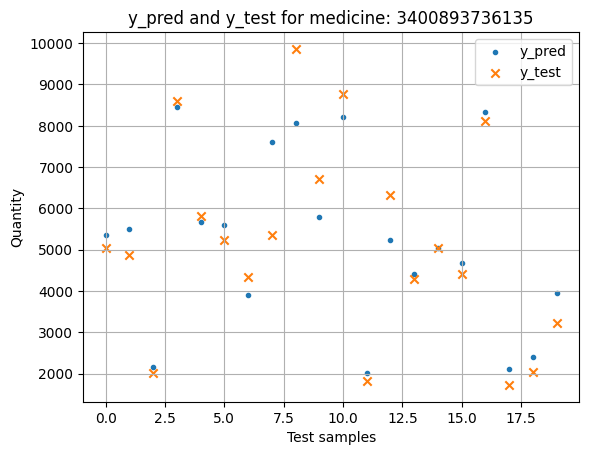



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Datapoints in test: 21
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 15}
Training Score: R^2 0.816
Test score: 
R^2 Score: 0.761
MAE: 1258.76
MAPE: 0.585
RMSE: 2355.282



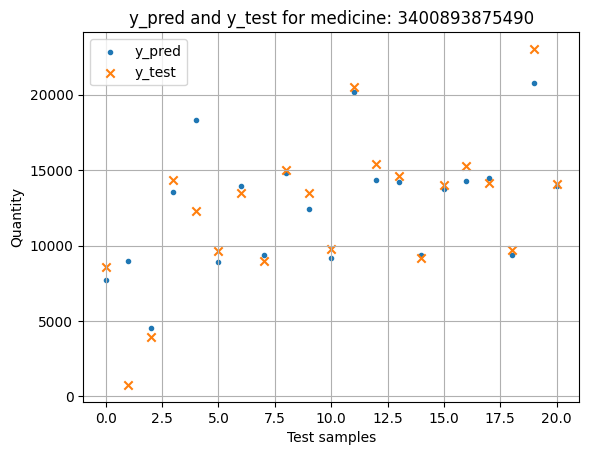



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Size of data set: 207
Size of training set: 186
Size of test set: 21
Size of grid search: 102
Datapoints in test: 21
Best Parameters: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 18}
Training Score: R^2 0.884
Test score: 
R^2 Score: 0.631
MAE: 1871.589
MAPE: 27.116
RMSE: 4118.306



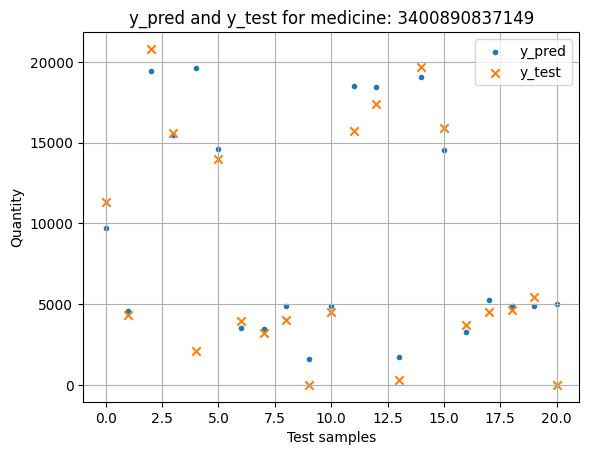



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Size of data set: 188
Size of training set: 169
Size of test set: 19
Size of grid search: 90
Datapoints in test: 19
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 14}
Training Score: R^2 0.916
Test score: 
R^2 Score: 0.964
MAE: 334.743
MAPE: 3.667
RMSE: 456.193



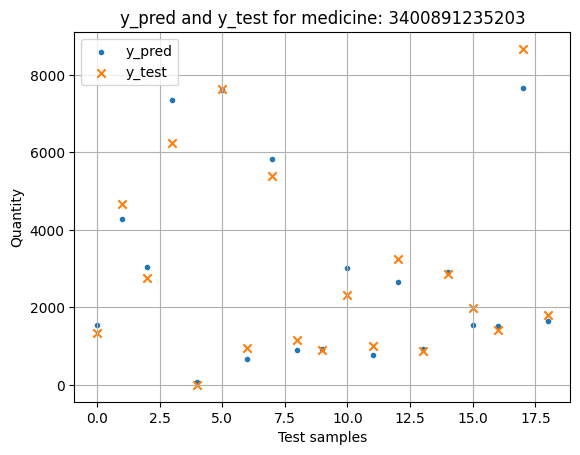



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Size of data set: 209
Size of training set: 188
Size of test set: 21
Size of grid search: 102
Datapoints in test: 21
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score: R^2 0.868
Test score: 
R^2 Score: 0.87
MAE: 1765.278
MAPE: 0.171
RMSE: 2741.799



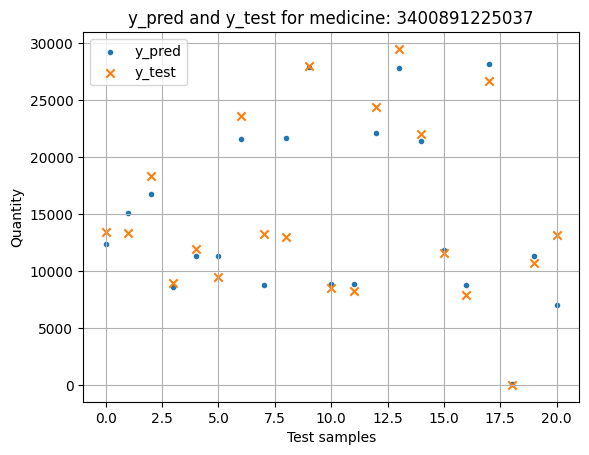



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Size of data set: 200
Size of training set: 180
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 9}
Training Score: R^2 0.807
Test score: 
R^2 Score: 0.868
MAE: 833.541
MAPE: 0.912
RMSE: 1194.713



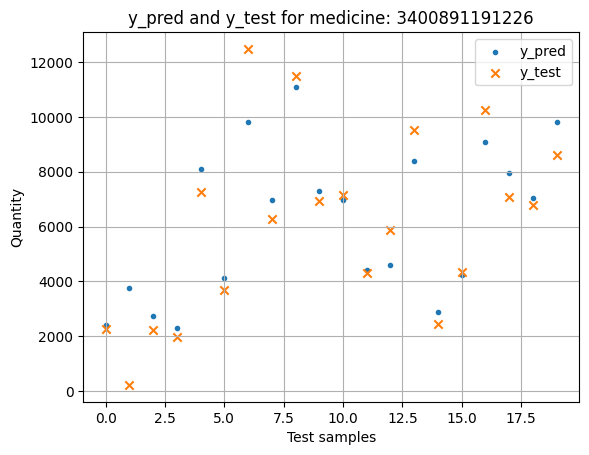



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Size of data set: 194
Size of training set: 174
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 9}
Training Score: R^2 0.719
Test score: 
R^2 Score: 0.751
MAE: 614.074
MAPE: 0.244
RMSE: 843.995



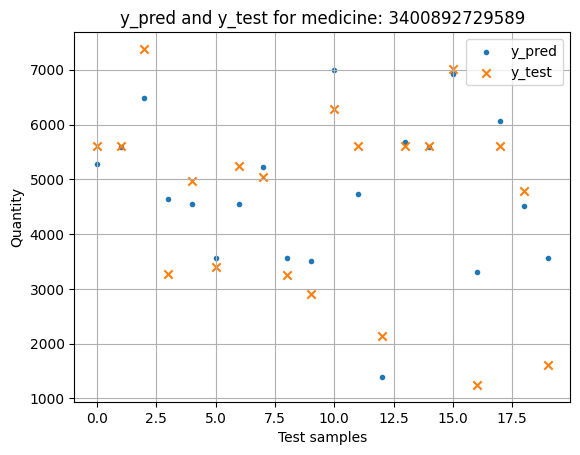



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Size of data set: 175
Size of training set: 157
Size of test set: 18
Size of grid search: 84
Datapoints in test: 18
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score: R^2 0.889
Test score: 
R^2 Score: -0.19
MAE: 2780.799
MAPE: 0.758
RMSE: 5946.927



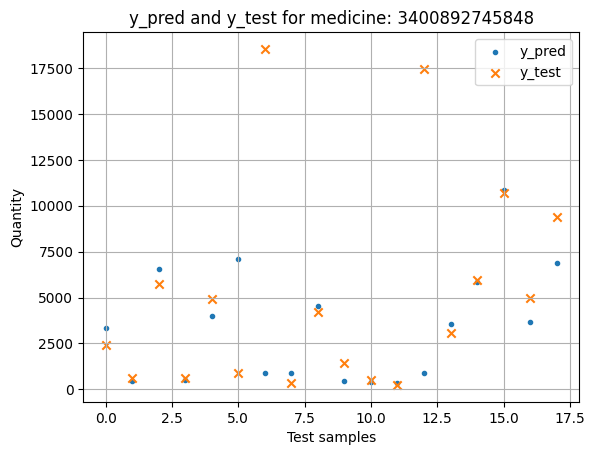



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Size of data set: 204
Size of training set: 183
Size of test set: 21
Size of grid search: 102
Datapoints in test: 21
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 18}
Training Score: R^2 0.694
Test score: 
R^2 Score: 0.819
MAE: 300.35
MAPE: 1.971
RMSE: 395.994



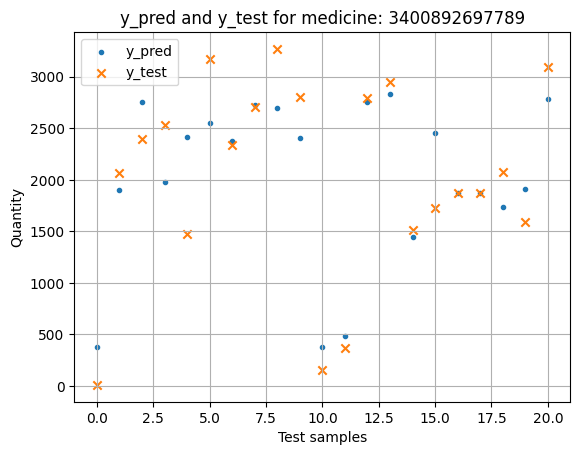



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Size of data set: 200
Size of training set: 180
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 4}
Training Score: R^2 0.96
Test score: 
R^2 Score: 0.938
MAE: 2068.345
MAPE: 0.771
RMSE: 2872.027



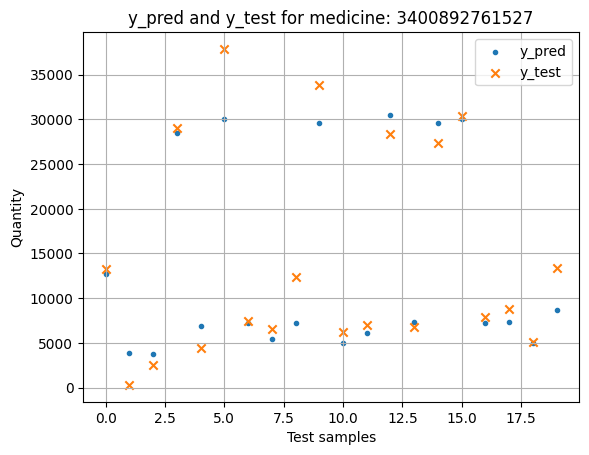



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Size of data set: 157
Size of training set: 141
Size of test set: 16
Size of grid search: 78
Datapoints in test: 16
Best Parameters: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 13}
Training Score: R^2 0.749
Test score: 
R^2 Score: 0.787
MAE: 584.148
MAPE: 4.074
RMSE: 834.755



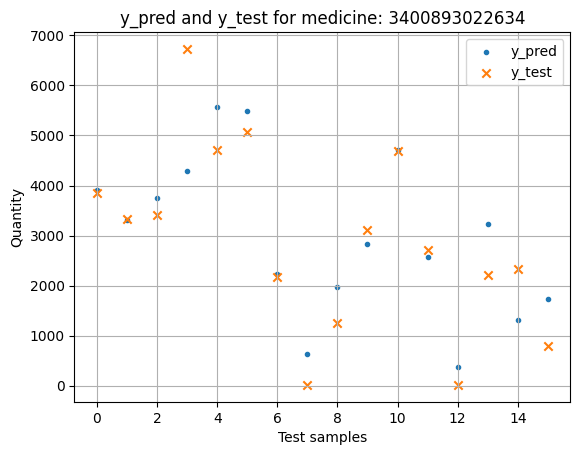



----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Datapoints in test: 21
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 13}
Training Score: R^2 0.96
Test score: 
R^2 Score: 0.982
MAE: 1131.291
MAPE: 2.615
RMSE: 1413.178



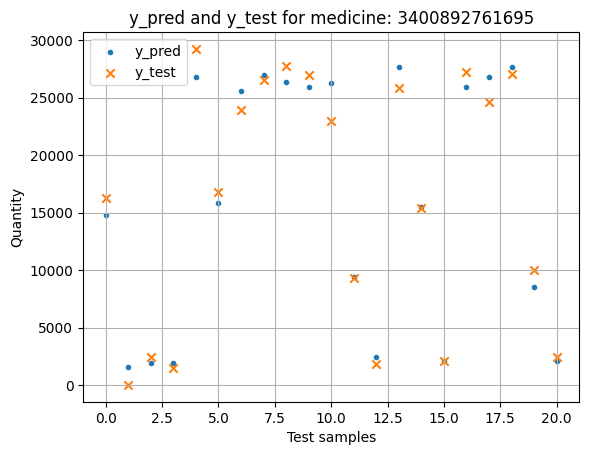



----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Size of data set: 173
Size of training set: 155
Size of test set: 18
Size of grid search: 84
Datapoints in test: 18
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 7}
Training Score: R^2 0.542
Test score: 
R^2 Score: -1.361
MAE: 840.215
MAPE: 0.084
RMSE: 1647.226



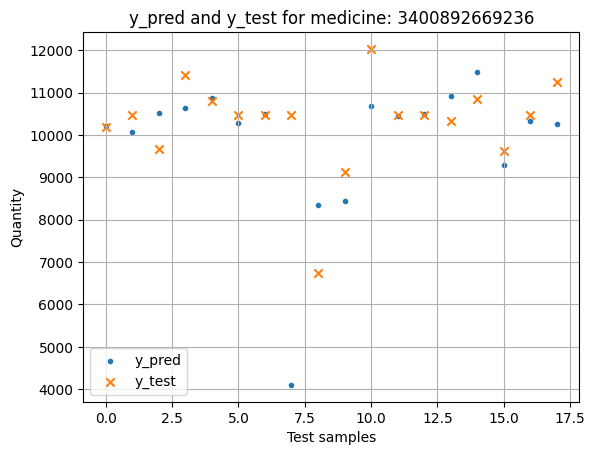



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Size of data set: 191
Size of training set: 171
Size of test set: 20
Size of grid search: 96
Datapoints in test: 20
Best Parameters: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 9}
Training Score: R^2 0.792
Test score: 
R^2 Score: 0.786
MAE: 779.766
MAPE: 0.602
RMSE: 1026.54



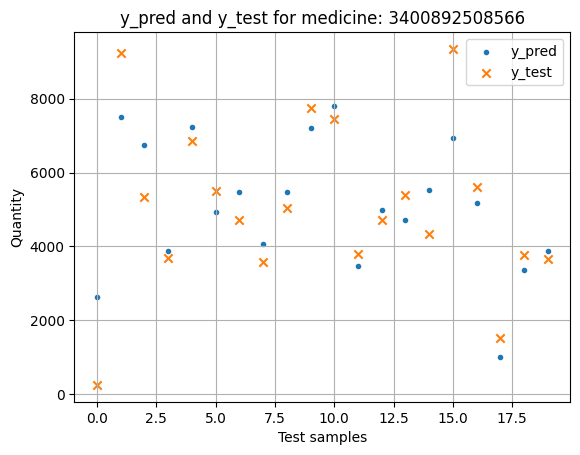

,HOSPI_CODE_UCD,R2,RMSE,MAE,MAPE
0,CODE_UCD_3400892088310,0.707802,1039.401196,720.811574,0.487358
1,CODE_UCD_3400892075761,0.411046,637.729372,385.029567,0.144093
2,CODE_UCD_3400892203645,0.924293,1090.205262,708.463423,1.029771
3,CODE_UCD_3400892065366,0.706377,1221.085610,710.501357,0.745146
4,CODE_UCD_3400892052120,0.905427,321.271064,220.996297,1.931228
5,CODE_UCD_3400891996128,0.897319,10693.292574,8777.960818,12.775924
6,CODE_UCD_3400893826706,0.823160,1167.964927,783.299305,4.254584
7,CODE_UCD_3400893736135,0.883707,792.741609,556.192051,0.115819
8,CODE_UCD_3400893875490,0.761003,2355.281775,1258.759629,0.585130
9,CODE_UCD_3400890837149,0.630799,4118.306396,1871.589130,27.116241


In [5]:
df_prediction_scores = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

for medicine in medicines:

  df_prediction_scores = test_1_baseline(df[features], medicine, df_prediction_scores)

df_prediction_scores

In [135]:
def train_test_split_modified(df, random_state = 42, test_size = 0.1, Shuffle = False):
  df_iter = df.copy()

  np.random.seed(random_state)

  X_train = []
  y_train = []

  X_test = []
  y_test = []

  columns = df.columns

  df_train = pd.DataFrame(columns=columns)
  df_test = pd.DataFrame(columns=columns)
  i = 0
  for medicine in df_iter.HOSPI_CODE_UCD.unique():
    df_temp = df_iter[df_iter['HOSPI_CODE_UCD'] == medicine]
    i += len(df_temp)
    n_samples = len(df_temp)
    test_samples = max(m.ceil(n_samples * test_size), 2)

    for _ in range(test_samples):
      random_index = np.random.choice(df_temp.index)
      random_row = df_temp.loc[random_index].to_frame().T

      # Concatenate the new row to the original DataFrame
      df_test = pd.concat([df_test, random_row], ignore_index=False)

      # Remove the selected index from df_temp
      df_temp = df_temp.drop(random_index)

    df_iter = df_iter.drop(df_iter[df_iter['HOSPI_CODE_UCD'] == medicine].index)

  # Get the indices of rows to exclude from df
  exclude_indices = df_test.index

  # Create df_train by dropping the rows specified by the exclude_indices from df
  df_train = df.drop(exclude_indices)

  if shuffle:
    X_train, y_train = shuffle(df_train.drop(['QUANTITY', 'QUANTITY_MA', 'CLUSTER'], axis=1), df_train.QUANTITY.values, random_state = random_state)
    X_test, y_test = shuffle(df_test.drop(['QUANTITY', 'QUANTITY_MA', 'CLUSTER'], axis=1).values, df_test.QUANTITY.values, random_state = random_state)

  return X_train, X_test, y_train, y_test

In [136]:
cluster = 0
X_train, X_test, y_train, y_test = train_test_split_modified(df_3_clusters[df_3_clusters['CLUSTER'] == cluster].copy())

In [137]:
def test_2_clustering(df, df_scores, medicines):
  for cluster in df.CLUSTER.unique():
    print()
    print(100*'-')
    print(f'Cluster: {cluster}')

    # Perform the train-test split with shuffled samples
    X_train, X_test, y_train, y_test = train_test_split_modified(df[df['CLUSTER'] == cluster])
    print(f'Size of data set: {len(X)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

    df_test = pd.DataFrame(X_test, columns = df.drop(['QUANTITY', 'QUANTITY_MA', 'CLUSTER'], axis=1).copy().columns)
    df_test['QUANTITY'] = y_test

    # Define the parameter distributions for RandomizedSearchCV
    param_grid = {
        'max_depth': np.arange(2, 8, 1),
        'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
        'max_features': ['sqrt']
    }

    depth_len = param_grid['max_depth'].size
    estimators_len = param_grid['n_estimators'].size

    print(f'Size of grid search: {depth_len * estimators_len}')

    # Create the RandomizedSearchCV object
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid,
                              scoring = 'r2',
                              cv = 5,
                              n_jobs = -1)

    ''' >3 : the fold and candidate parameter indexes
        are also displayed together with the starting time of the computation.
    '''

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Fit the RandomizedSearchCV object to the data
    grid_search.fit(X_train_scaled, y_train)
    print("Finished training")

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    for medicine in df_test.HOSPI_CODE_UCD.unique():
      print()
      print(100*'-')
      print('Medicine:' + str(medicine))

      X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY'], axis=1).copy().values

      scaler = StandardScaler()
      X_test_scaled = scaler.fit_transform(X_test_medicine)

      y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

      # Make predictions using the best estimator
      y_pred = best_estimator.predict(X_test_scaled)

      # Calculate R^2 score
      r2 = r2_score(y_test_medicine, y_pred)

      # Calculate MAE
      mae = mean_absolute_error(y_test_medicine, y_pred)

      # Calculate MAPE
      mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

      # Print the best parameters, best score, and evaluation metrics

      print(f'Datapoints in test: {len(X_test_medicine)}')
      print('Best Parameters:', grid_search.best_params_)
      print('Training Score: R^2', round(grid_search.best_score_, 3))
      print('Test score: ')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()


      # Create the new row as a DataFrame
      new_row = pd.DataFrame({'CLUSTER': [cluster],
                              'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                              'R2': [r2],
                              'RMSE': [rmse],
                              'MAE': [mae],
                              'MAPE': [mape]})

      # Append the new row to the DataFrame
      df_scores = pd.concat([df_scores, new_row], ignore_index=True)

      plot_pred(y_pred, y_test_medicine, medicine)
      print()

  # Return the updated DataFrame
  return df_scores

In [ ]:

df_prediction_scores_3_clusters = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_3_clusters = test_2_clustering(df_3_clusters, df_prediction_scores_3_clusters, medicines)

df_prediction_scores_3_clusters


----------------------------------------------------------------------------------------------------
Cluster: 0
Size of data set: 1906
Size of training set: 1706
Size of test set: 200
Size of grid search: 1014



----------------------------------------------------------------------------------------------------
Cluster: 0
Size of data set: 1208
Size of training set: 1087
Size of test set: 121
Size of grid search: 642
Finished training

----------------------------------------------------------------------------------------------------
Medicine:3400891996128.0
Datapoints in test: 6
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -3.161
MAE: 37462.981
MAPE: 14.664
RMSE: 41845.206



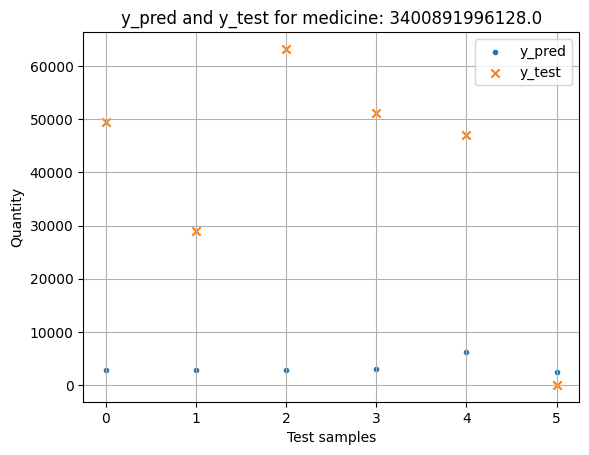



----------------------------------------------------------------------------------------------------
Medicine:3400893875490.0
Datapoints in test: 5
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -420.219
MAE: 5835.438
MAPE: 0.62
RMSE: 5985.064



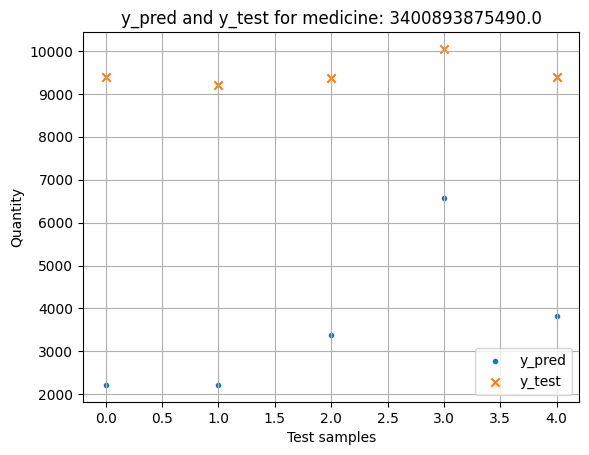



----------------------------------------------------------------------------------------------------
Medicine:3400892052120.0
Datapoints in test: 6
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -1.241
MAE: 1319.181
MAPE: 27.821
RMSE: 1777.309



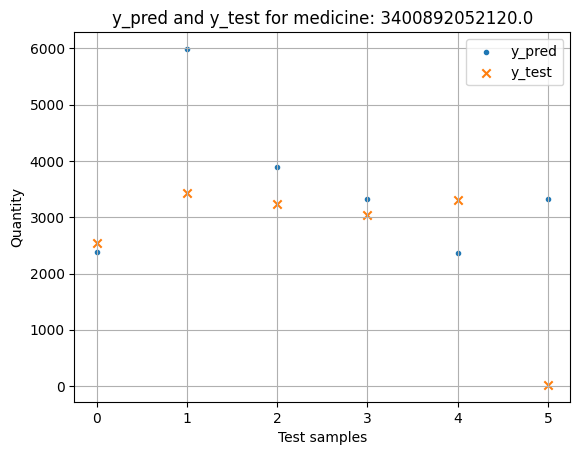



----------------------------------------------------------------------------------------------------
Medicine:3400890837149.0
Datapoints in test: 9
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: 0.547
MAE: 2543.483
MAPE: 22.764
RMSE: 2899.615



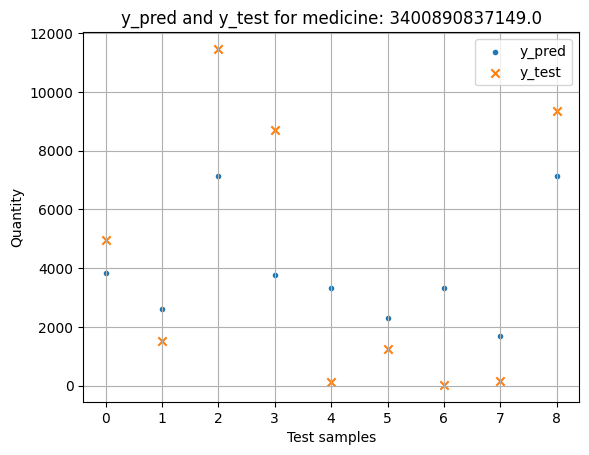



----------------------------------------------------------------------------------------------------
Medicine:3400893826706.0
Datapoints in test: 10
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -0.796
MAE: 1161.082
MAPE: 335.698
RMSE: 1764.717



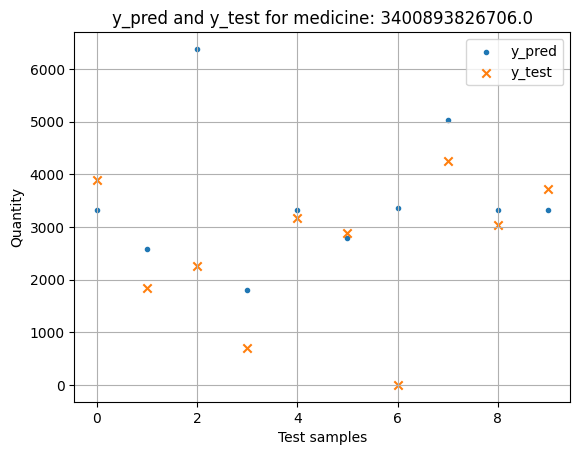



----------------------------------------------------------------------------------------------------
Medicine:3400892761527.0
Datapoints in test: 3
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -0.757
MAE: 3480.811
MAPE: 0.416
RMSE: 4330.689



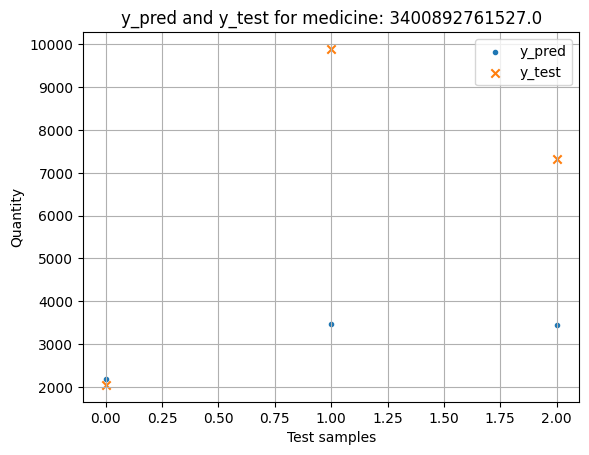



----------------------------------------------------------------------------------------------------
Medicine:3400892669236.0
Datapoints in test: 7
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -110.251
MAE: 6207.0
MAPE: 0.629
RMSE: 6358.401



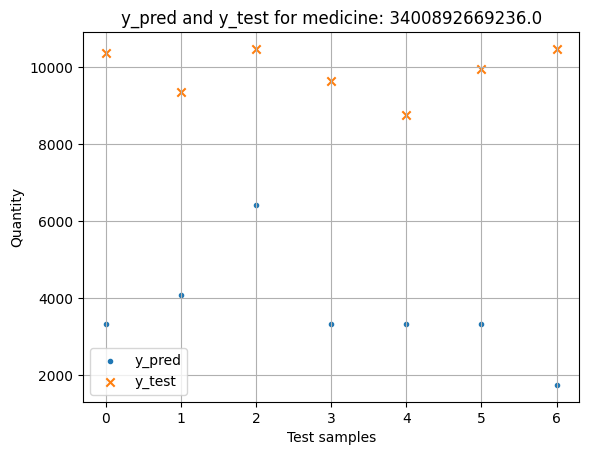



----------------------------------------------------------------------------------------------------
Medicine:3400892729589.0
Datapoints in test: 5
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -0.069
MAE: 687.586
MAPE: 0.151
RMSE: 1039.793



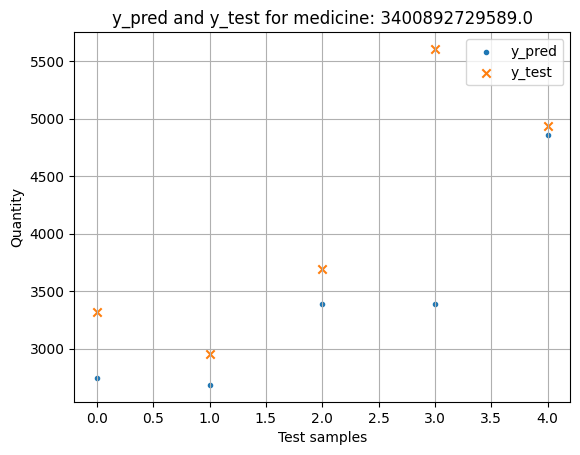



----------------------------------------------------------------------------------------------------
Medicine:3400892065366.0
Datapoints in test: 8
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: 0.242
MAE: 635.864
MAPE: 0.145
RMSE: 993.929



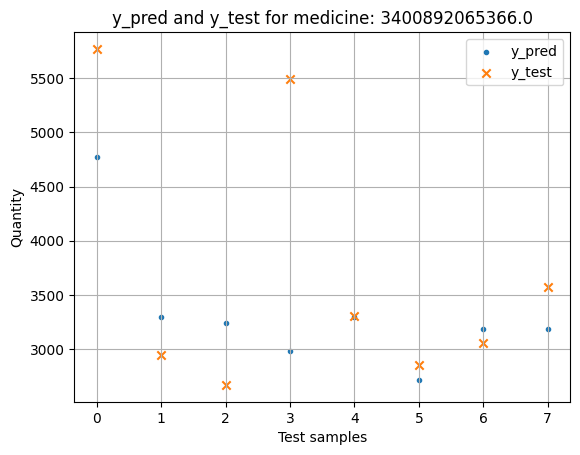



----------------------------------------------------------------------------------------------------
Medicine:3400892075761.0
Datapoints in test: 5
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -7.629
MAE: 1917.553
MAPE: 1.207
RMSE: 2192.876



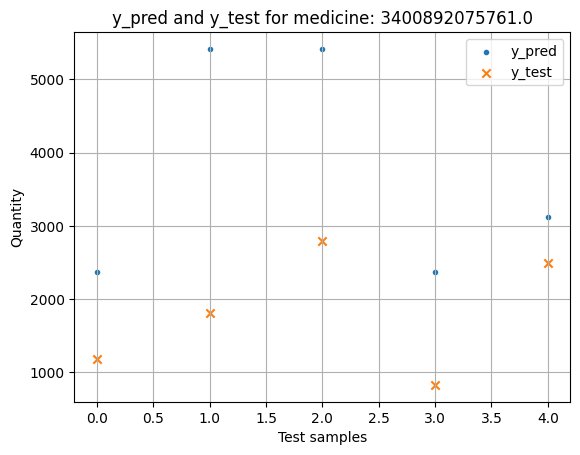



----------------------------------------------------------------------------------------------------
Medicine:3400892508566.0
Datapoints in test: 4
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -0.685
MAE: 1915.589
MAPE: 12.621
RMSE: 2110.659



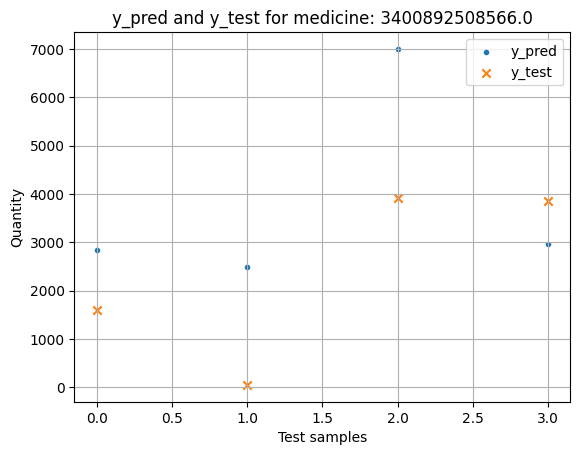



----------------------------------------------------------------------------------------------------
Medicine:3400892745848.0
Datapoints in test: 8
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -7.387
MAE: 3975.183
MAPE: 0.512
RMSE: 4258.257



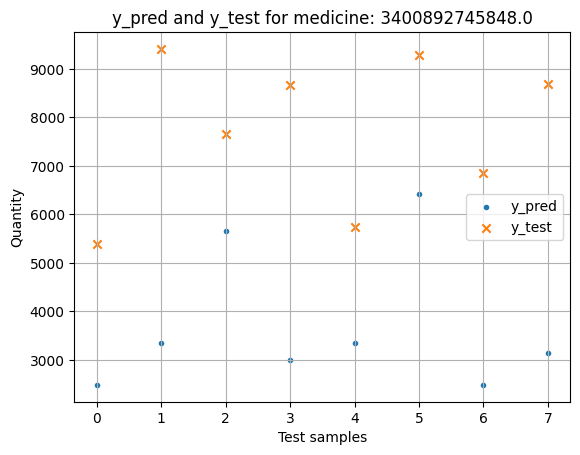



----------------------------------------------------------------------------------------------------
Medicine:3400893022634.0
Datapoints in test: 7
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -1.632
MAE: 1651.165
MAPE: 134.669
RMSE: 1961.96



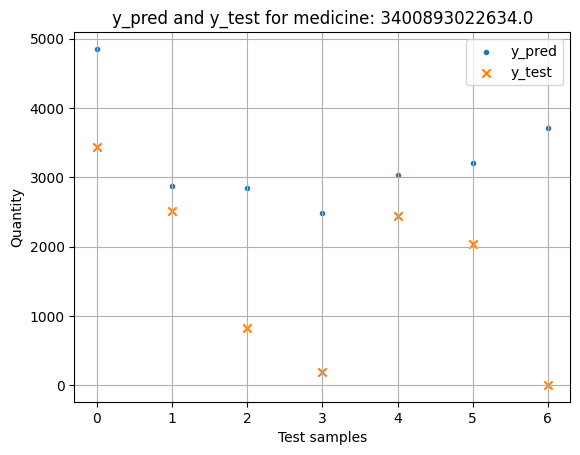



----------------------------------------------------------------------------------------------------
Medicine:3400892088310.0
Datapoints in test: 4
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -4.541
MAE: 2185.017
MAPE: 4.707
RMSE: 2410.068



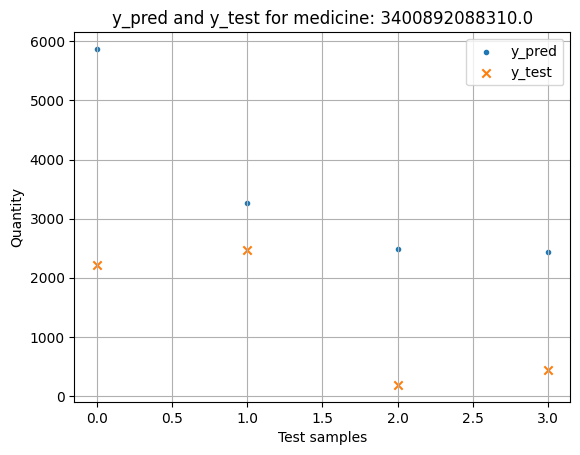



----------------------------------------------------------------------------------------------------
Medicine:3400892761695.0
Datapoints in test: 6
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -23.462
MAE: 1784.846
MAPE: 0.918
RMSE: 1964.822



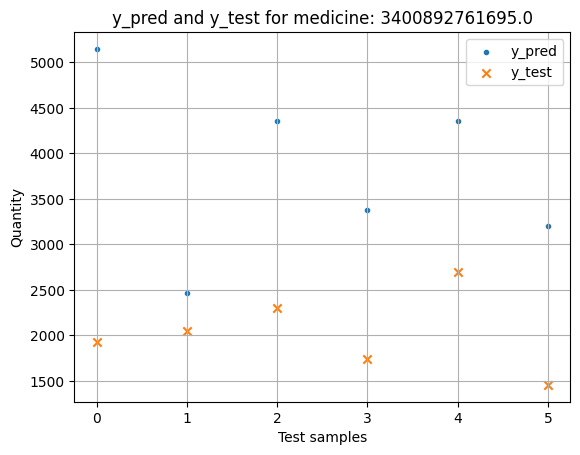



----------------------------------------------------------------------------------------------------
Medicine:3400892203645.0
Datapoints in test: 12
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -24.984
MAE: 2801.297
MAPE: 14.269
RMSE: 2989.985



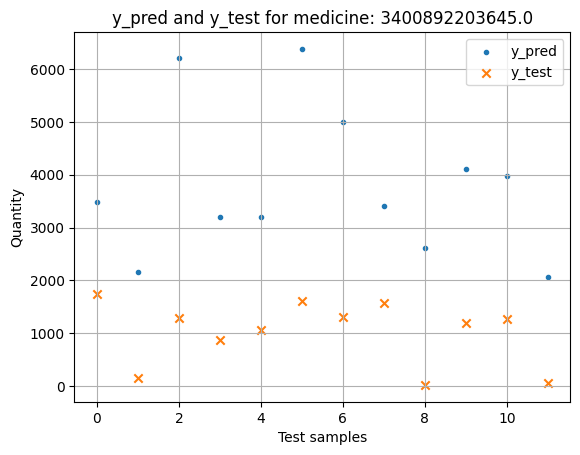



----------------------------------------------------------------------------------------------------
Medicine:3400892697789.0
Datapoints in test: 6
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -10.69
MAE: 1791.012
MAPE: 1.74
RMSE: 1936.092



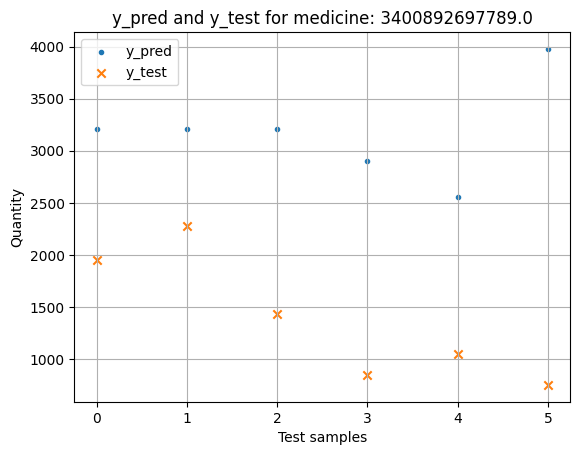



----------------------------------------------------------------------------------------------------
Medicine:3400891191226.0
Datapoints in test: 2
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -72.691
MAE: 1473.58
MAPE: 0.649
RMSE: 1716.874



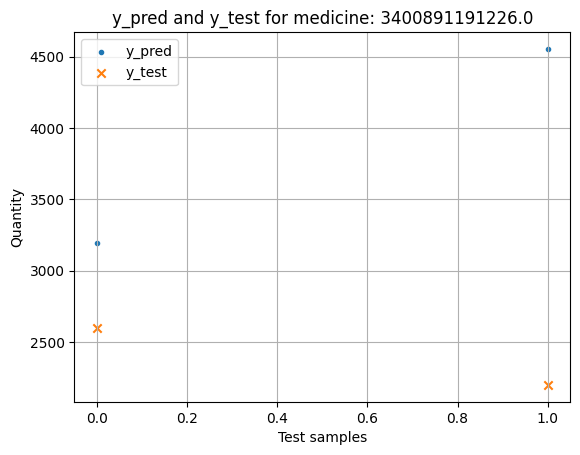



----------------------------------------------------------------------------------------------------
Medicine:3400891225037.0
Datapoints in test: 5
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -4.377
MAE: 9138.819
MAPE: 0.699
RMSE: 9720.173



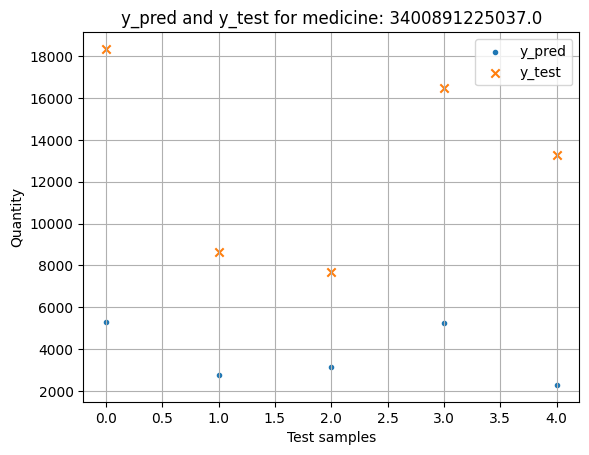



----------------------------------------------------------------------------------------------------
Medicine:3400893736135.0
Datapoints in test: 2
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: -0.576
MAE: 1944.842
MAPE: 25.356
RMSE: 1945.756



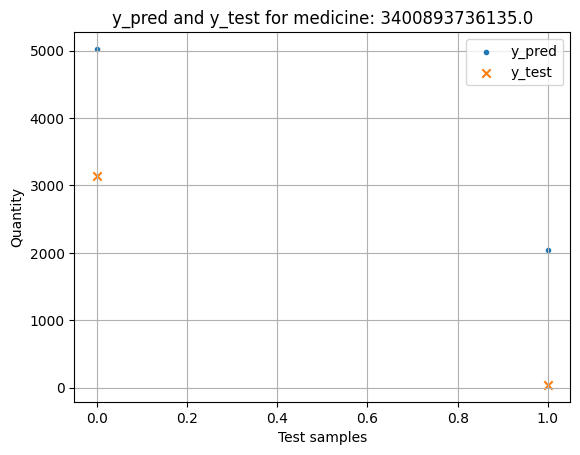



----------------------------------------------------------------------------------------------------
Medicine:3400891235203.0
Datapoints in test: 1
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score: R^2 0.891
Test score: 
R^2 Score: nan
MAE: 2200.991
MAPE: 0.432
RMSE: 2200.991



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


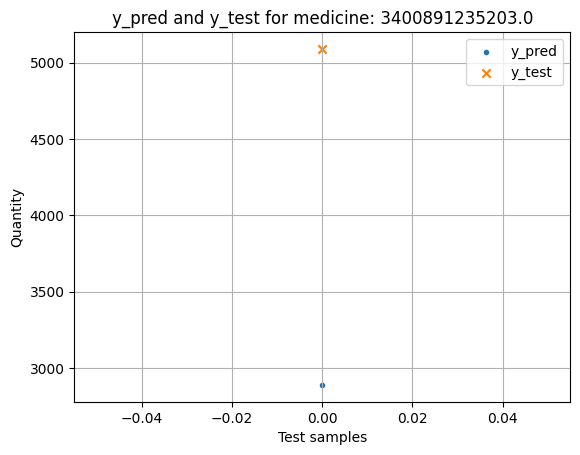



----------------------------------------------------------------------------------------------------
Cluster: 1
Size of data set: 1398
Size of training set: 1258
Size of test set: 140
Size of grid search: 744


KeyboardInterrupt: ignored

In [17]:
df_prediction_scores_4_clusters = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_4_clusters = test_2_clustering(df_4_clusters, df_prediction_scores_4_clusters, medicines)

df_prediction_scores_4_clusters

In [ ]:
df_prediction_scores_5_clusters = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_5_clusters = test_2_clustering(df_5_clusters, df_prediction_scores_5_clusters, medicines)

df_prediction_scores_5_clusters